Boxes drawn: 0


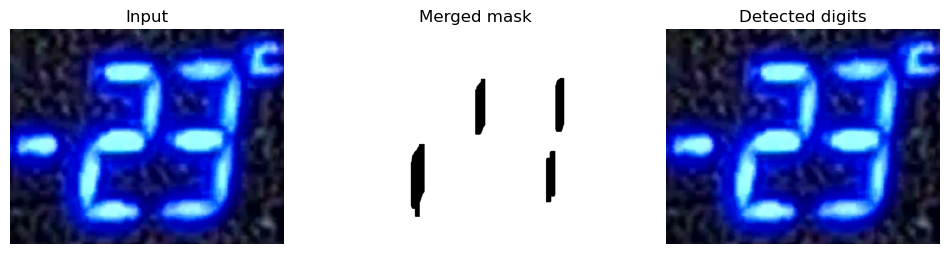

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from imutils.contours import sort_contours

# Target image (full crop containing multiple digits/symbols)
CROP_PATH = "digits_crops/digit_1.png"
img = cv2.imread(CROP_PATH)
assert img is not None, f"Image not found: {CROP_PATH}"
vis = img.copy()

# 1) Grayscale + threshold (invert so foreground is white)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)
_, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
if np.count_nonzero(th == 255) < np.count_nonzero(th == 0):
    th = cv2.bitwise_not(th)

# 2) Morphology to MERGE 7-seg bars into a single blob per digit
h, w = th.shape[:2]
# rectangular kernel: wider vertically to connect top/middle/bottom segments
connect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, max(9, h // 10)))
merged = cv2.morphologyEx(th, cv2.MORPH_CLOSE, connect_kernel, iterations=2)
# small opening to remove specks such as degree symbol
noise_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
merged = cv2.morphologyEx(merged, cv2.MORPH_OPEN, noise_kernel, iterations=1)

# Optional thinning of thick blobs
merged = cv2.erode(merged, noise_kernel, iterations=1)

# 3) Find external contours (per-digit candidates)
contours, _ = cv2.findContours(merged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 4) Filter by geometry to keep digit-like regions
min_h = int(0.35 * h)    # tall enough
min_w = int(0.06 * w)
min_area = int(0.01 * w * h)
max_area = int(0.6 * w * h)

candidates = []
for c in contours:
    x, y, cw, ch = cv2.boundingRect(c)
    area = cw * ch
    if cw >= min_w and ch >= min_h and min_area <= area <= max_area:
        candidates.append(c)

# 5) Choose the three left-to-right widest/tallest blobs as digits (ignore small degree symbol)
if len(candidates) > 0:
    # Prefer height, then width
    candidates = sorted(candidates, key=lambda c: (cv2.boundingRect(c)[3], cv2.boundingRect(c)[2]), reverse=True)
    candidates = candidates[:3]
    candidates = list(sort_contours(candidates, method="left-to-right")[0])

# 6) Draw boxes
for c in candidates:
    x, y, cw, ch = cv2.boundingRect(c)
    cv2.rectangle(vis, (x, y), (x + cw, y + ch), (0, 255, 0), 3)

print(f"Boxes drawn: {len(candidates)}")

# 7) Visualize
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("Input"); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.subplot(1,3,2); plt.title("Merged mask"); plt.imshow(merged, cmap='gray'); plt.axis('off')
plt.subplot(1,3,3); plt.title("Detected digits"); plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.show()


Saved 1 digit crops to digits_crops


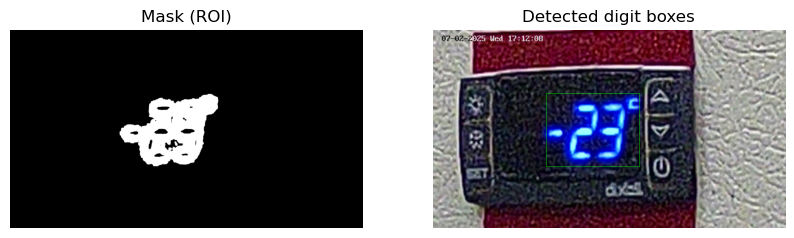

In [10]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# -------- Settings --------
IMAGE_PATH = "digit.jpg"   # change if needed
OUTPUT_DIR = "digits_crops"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# -------- Load image --------
img_bgr = cv2.imread(IMAGE_PATH)
assert img_bgr is not None, f"Image not found: {IMAGE_PATH}"
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# -------- Segment blue LEDs (ROI mask) --------
hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
# range for bright blue LEDs; adjust if needed
lower_blue = np.array([90, 120, 120], dtype=np.uint8)
upper_blue = np.array([130, 255, 255], dtype=np.uint8)
mask = cv2.inRange(hsv, lower_blue, upper_blue)

# Clean mask
kernel = np.ones((3,3), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
mask = cv2.dilate(mask, np.ones((5,5), np.uint8), iterations=2)

# If nothing detected, try a wider range
if mask.sum() == 0:
    lower_blue2 = np.array([85, 50, 50], dtype=np.uint8)
    upper_blue2 = np.array([140, 255, 255], dtype=np.uint8)
    mask = cv2.inRange(hsv, lower_blue2, upper_blue2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    mask = cv2.dilate(mask, np.ones((5,5), np.uint8), iterations=2)

# -------- Find overall display ROI (optional) --------
coords = cv2.findNonZero(mask)
if coords is not None:
    x, y, w, h = cv2.boundingRect(coords)
    pad = 10
    x0 = max(x - pad, 0)
    y0 = max(y - pad, 0)
    x1 = min(x + w + pad, img_bgr.shape[1])
    y1 = min(y + h + pad, img_bgr.shape[0])
    display_roi = img_bgr[y0:y1, x0:x1]
    mask_roi = mask[y0:y1, x0:x1]
else:
    # fallback to full image
    x0, y0 = 0, 0
    display_roi = img_bgr.copy()
    mask_roi = mask.copy()

# -------- Derive per-digit horizontal spans via projection --------
col_sum = (mask_roi > 0).sum(axis=0)
# dynamic threshold proportional to ROI height
min_col_on = max(5, int(0.18 * mask_roi.shape[0]))
active = col_sum > min_col_on

# find contiguous runs of True
spans = []
in_run = False
start = 0
for i, val in enumerate(active):
    if val and not in_run:
        in_run = True
        start = i
    elif not val and in_run:
        in_run = False
        end = i - 1
        spans.append((start, end))
# close last run
if in_run:
    spans.append((start, len(active)-1))

# merge very close spans (small gaps)
merged = []
GAP = max(2, int(0.02 * mask_roi.shape[1]))
for s, e in spans:
    if not merged:
        merged.append([s, e])
    else:
        if s - merged[-1][1] <= GAP:
            merged[-1][1] = e
        else:
            merged.append([s, e])

# filter out tiny spans
min_width = max(6, int(0.03 * mask_roi.shape[1]))
digit_spans = [(s, e) for s, e in merged if (e - s + 1) >= min_width]

# Keep the 3 widest spans (likely -, 2, 3); drop tiny °/C
digit_spans = sorted(digit_spans, key=lambda p: p[1]-p[0]+1, reverse=True)[:3]
digit_spans = sorted(digit_spans, key=lambda p: p[0])  # left→right

# Drop spans that are too short vertically (e.g., the small degree symbol)
filtered = []
for xs, xe in digit_spans:
    submask = mask_roi[:, xs:xe+1]
    rows_sum = (submask > 0).sum(axis=1)
    height_ratio = rows_sum.max() / max(1, submask.shape[1])
    if height_ratio < 0.30:
        continue
    filtered.append((xs, xe))
digit_spans = filtered

# -------- Compute bounding boxes and save crops --------
crops = []
margin = 4
for idx, (xs, xe) in enumerate(digit_spans):
    submask = mask_roi[:, xs:xe+1]
    rows_sum = (submask > 0).sum(axis=1)
    min_row_on = max(3, int(0.03 * submask.shape[1]))
    rows_active = rows_sum > min_row_on
    if rows_active.any():
        y_top = int(np.argmax(rows_active))
        y_bottom = int(len(rows_active) - 1 - np.argmax(rows_active[::-1]))
    else:
        y_top, y_bottom = 0, mask_roi.shape[0]-1

    # expand with margins and map back to original image coords
    xA = max(xs + x0 - margin, 0)
    xB = min(xe + x0 + margin, img_bgr.shape[1]-1)
    yA = max(y_top + y0 - margin, 0)
    yB = min(y_bottom + y0 + margin, img_bgr.shape[0]-1)

    crop = img_bgr[yA:yB+1, xA:xB+1]
    if crop.size == 0:
        continue
    crops.append(((xA, yA, xB, yB), crop))
    out_path = os.path.join(OUTPUT_DIR, f"digit_{idx+1}.png")
    cv2.imwrite(out_path, crop)

print(f"Saved {len(crops)} digit crops to {OUTPUT_DIR}")

# -------- Visualize detections --------
vis = img_rgb.copy()
for (xA, yA, xB, yB), _ in crops:
    cv2.rectangle(vis, (xA, yA), (xB, yB), (0, 255, 0), 2)

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.title("Mask (ROI)")
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Detected digit boxes")
plt.imshow(vis)
plt.axis('off')
plt.show()



Found 0 candidate digit contour(s)


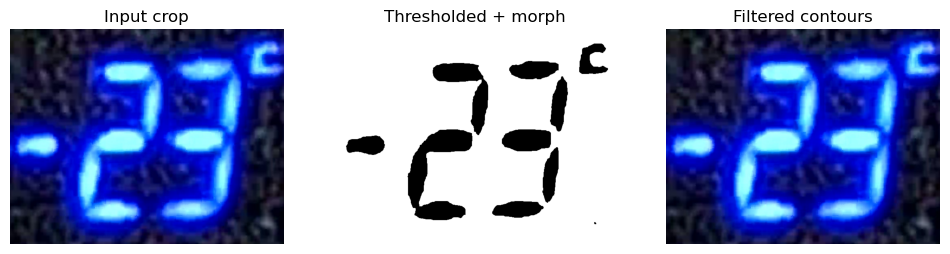

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from imutils.contours import sort_contours

# ----- Load cropped digit image -----
CROP_PATH = "digits_crops/digit_1.png"
img = cv2.imread(CROP_PATH)
assert img is not None, f"Cropped image not found: {CROP_PATH}"
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# ----- Thresholding -----
# Use Gaussian blur to suppress noise then Otsu's threshold.
blur = cv2.GaussianBlur(gray, (5, 5), 0)
_, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Ensure digits are white for contour detection on the cleaned mask as well
if np.count_nonzero(thresh == 255) < np.count_nonzero(thresh == 0):
    thresh = cv2.bitwise_not(thresh)

# ----- Morphological cleanup -----
kernel_small = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
# Remove small noise
clean = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel_small, iterations=1)
# Bridge small gaps within segments
clean = cv2.morphologyEx(clean, cv2.MORPH_CLOSE, kernel_small, iterations=2)
# Light dilation to thicken segments slightly
clean = cv2.dilate(clean, kernel_small, iterations=1)

# Final check: foreground must be white for contour detection
if np.count_nonzero(clean == 255) < np.count_nonzero(clean == 0):
    clean = cv2.bitwise_not(clean)

# ----- Find contours -----
contours, _ = cv2.findContours(clean.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# ----- Filter contours and initialize digitsCnts -----
(h, w) = clean.shape[:2]
min_w = max(4, int(0.04 * w))
min_h = max(8, int(0.15 * h))
max_h = int(0.98 * h)
min_area = int(0.0015 * w * h)

digitsCnts = []  # list to store digit contours

for c in contours:
    x, y, cw, ch = cv2.boundingRect(c)
    area = cv2.contourArea(c)
    if cw >= min_w and min_h <= ch <= max_h and area >= min_area:
        digitsCnts.append(c)

# Sort contours from left-to-right
if len(digitsCnts) > 1:
    digitsCnts = list(sort_contours(digitsCnts, method="left-to-right")[0])

print(f"Found {len(digitsCnts)} candidate digit contour(s)")

# ----- Visualization -----
vis = img.copy()
for c in digitsCnts:
    x, y, cw, ch = cv2.boundingRect(c)
    cv2.rectangle(vis, (x, y), (x + cw, y + ch), (0, 255, 0), 2)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Input crop")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Thresholded + morph")
plt.imshow(clean, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Filtered contours")
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


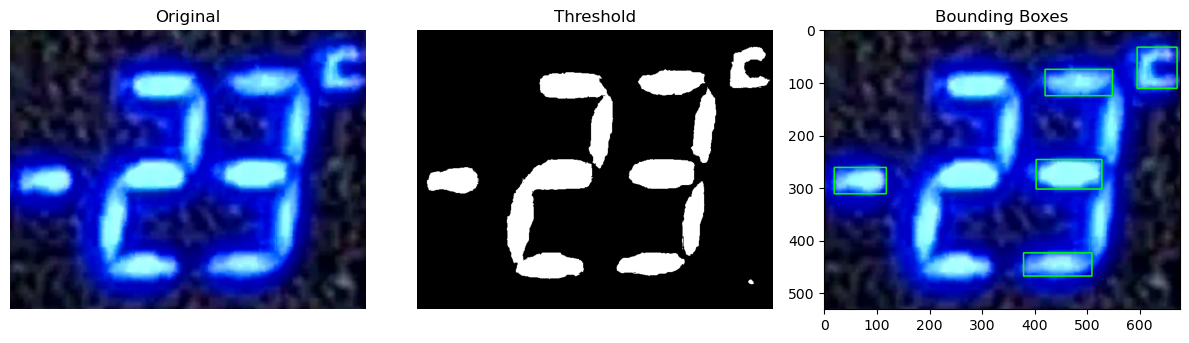

In [16]:
import cv2
import imutils
import matplotlib.pyplot as plt

# === Step 1: Load cropped image ===
img = cv2.imread("digits_crops/digit_1.png")
output = img.copy()

# === Step 2: Grayscale + Threshold ===
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# === Step 3: Find contours ===
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

digitCnts = []
for c in cnts:
    (x, y, w, h) = cv2.boundingRect(c)
    # filter: sufficiently large to be a digit
    if w >= 10 and (10 <= h <= 120):   # relaxed height (tune if needed)
        digitCnts.append(c)

# === Step 4: Sort left-to-right ===
digitCnts = sorted(digitCnts, key=lambda c: cv2.boundingRect(c)[0])

# === Step 5: Draw bounding boxes ===
for c in digitCnts:
    (x, y, w, h) = cv2.boundingRect(c)
    cv2.rectangle(output, (x,y), (x+w,y+h), (0,255,0), 2)

# === Step 6: Visualization with Matplotlib ===
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Threshold")
plt.imshow(thresh, cmap="gray")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Bounding Boxes")
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.axis("on")

plt.tight_layout()
plt.show()


Image dimensions: 677x531
Found 1619 total contours
Digit 1: x=363, y=511, w=16, h=16, area=86, aspect=1.00
Digit 2: x=152, y=509, w=11, h=18, area=67, aspect=0.61
Digit 3: x=475, y=508, w=17, h=14, area=78, aspect=1.21
Digit 4: x=530, y=490, w=23, h=13, area=68, aspect=1.77
Digit 5: x=611, y=483, w=34, h=35, area=246, aspect=0.97
Digit 6: x=440, y=463, w=47, h=20, area=178, aspect=2.35
Digit 7: x=395, y=463, w=43, h=19, area=178, aspect=2.26
Digit 8: x=186, y=463, w=12, h=16, area=62, aspect=0.75
Digit 9: x=273, y=461, w=56, h=24, area=320, aspect=2.33
Digit 10: x=475, y=458, w=25, h=14, area=72, aspect=1.79
Digit 11: x=492, y=447, w=15, h=25, area=90, aspect=0.60
Digit 12: x=180, y=443, w=15, h=19, area=75, aspect=0.79
Digit 13: x=0, y=434, w=28, h=13, area=68, aspect=2.15
Digit 14: x=373, y=422, w=22, h=37, area=150, aspect=0.59
Digit 15: x=617, y=419, w=19, h=12, area=66, aspect=1.58
Digit 16: x=194, y=410, w=136, h=51, area=1094, aspect=2.67
Digit 17: x=116, y=375, w=10, h=23, are

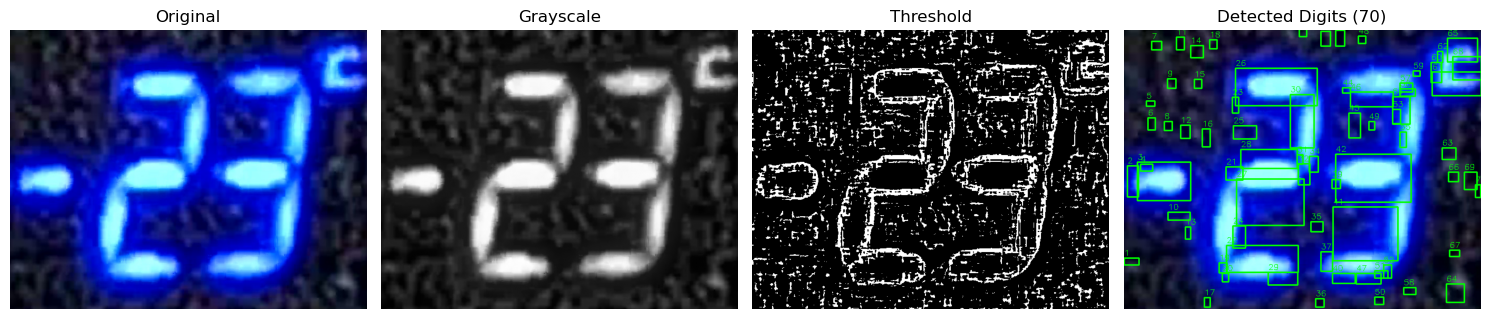

Extracted 70 digit ROIs


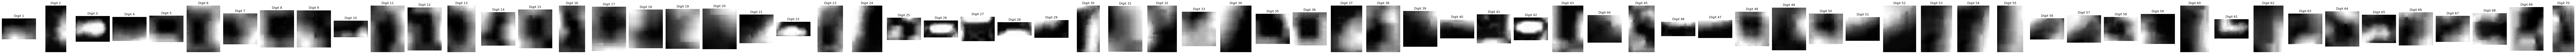

In [17]:
import cv2
import imutils
import matplotlib.pyplot as plt
import numpy as np

def detect_digits(image_path, min_width=10, min_height=10, max_height=120, 
                  aspect_ratio_range=(0.3, 3.0), area_threshold=50):
    """
    Enhanced digit detection with configurable parameters
    
    Args:
        image_path: Path to input image
        min_width: Minimum width for digit detection
        min_height: Minimum height for digit detection  
        max_height: Maximum height for digit detection
        aspect_ratio_range: (min, max) aspect ratio for digits
        area_threshold: Minimum contour area
    """
    
    # === Step 1: Load and validate image ===
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Could not load image: {image_path}")
    
    output = img.copy()
    height, width = img.shape[:2]
    print(f"Image dimensions: {width}x{height}")

    # === Step 2: Preprocessing ===
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Optional: Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    
    # Adaptive thresholding often works better than Otsu for varied lighting
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                  cv2.THRESH_BINARY_INV, 11, 2)
    
    # Alternative: Use Otsu thresholding
    # _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # === Step 3: Morphological operations to clean up ===
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # === Step 4: Find contours ===
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    print(f"Found {len(cnts)} total contours")

    # === Step 5: Enhanced filtering ===
    digitCnts = []
    for i, c in enumerate(cnts):
        (x, y, w, h) = cv2.boundingRect(c)
        area = cv2.contourArea(c)
        aspect_ratio = w / float(h)
        
        # Multiple criteria for better filtering
        if (w >= min_width and min_height <= h <= max_height and 
            area >= area_threshold and
            aspect_ratio_range[0] <= aspect_ratio <= aspect_ratio_range[1]):
            digitCnts.append(c)
            print(f"Digit {len(digitCnts)}: x={x}, y={y}, w={w}, h={h}, area={area:.0f}, aspect={aspect_ratio:.2f}")

    print(f"Detected {len(digitCnts)} potential digits after filtering")

    # === Step 6: Sort left-to-right ===
    digitCnts = sorted(digitCnts, key=lambda c: cv2.boundingRect(c)[0])

    # === Step 7: Draw bounding boxes with labels ===
    for i, c in enumerate(digitCnts):
        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)
        # Add digit number label
        cv2.putText(output, str(i+1), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 
                   0.5, (0, 255, 0), 1)

    # === Step 8: Enhanced visualization ===
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 4, 1)
    plt.title("Original")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.title("Grayscale")
    plt.imshow(gray, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.title("Threshold")
    plt.imshow(thresh, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.title(f"Detected Digits ({len(digitCnts)})")
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.tight_layout()
    plt.show()
    
    return digitCnts, output

def extract_digit_rois(image_path, digitCnts, padding=5):
    """
    Extract individual digit ROIs for further processing (e.g., OCR)
    
    Args:
        image_path: Path to original image
        digitCnts: List of digit contours
        padding: Padding around each digit
    """
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    digit_rois = []
    for i, c in enumerate(digitCnts):
        (x, y, w, h) = cv2.boundingRect(c)
        
        # Add padding but ensure we stay within image bounds
        x_pad = max(0, x - padding)
        y_pad = max(0, y - padding)
        w_pad = min(img.shape[1] - x_pad, w + 2*padding)
        h_pad = min(img.shape[0] - y_pad, h + 2*padding)
        
        roi = gray[y_pad:y_pad + h_pad, x_pad:x_pad + w_pad]
        digit_rois.append(roi)
        
        # Optionally save individual digits
        cv2.imwrite(f"extracted_digit_{i+1}.png", roi)
    
    return digit_rois

# === Usage Example ===
if __name__ == "__main__":
    try:
        # Main detection
        image_path = "digits_crops/digit_1.png"
        digitCnts, output = detect_digits(image_path)
        
        # Extract individual digit ROIs
        if digitCnts:
            digit_rois = extract_digit_rois(image_path, digitCnts)
            print(f"Extracted {len(digit_rois)} digit ROIs")
            
            # Display individual digits
            if digit_rois:
                fig, axes = plt.subplots(1, len(digit_rois), figsize=(2*len(digit_rois), 3))
                if len(digit_rois) == 1:
                    axes = [axes]
                
                for i, roi in enumerate(digit_rois):
                    axes[i].imshow(roi, cmap='gray')
                    axes[i].set_title(f'Digit {i+1}')
                    axes[i].axis('off')
                
                plt.tight_layout()
                plt.show()
        
    except FileNotFoundError as e:
        print(f"Error: {e}")
        print("Make sure the image path is correct and the file exists.")
    except Exception as e:
        print(f"An error occurred: {e}")

=== Method 1: Enhanced Morphological Approach ===
Image dimensions: 677x531
Found 8 total contours after morphological operations
Digit 1: x=406, y=249, w=142, h=183, area=9720, aspect=0.78
Digit 2: x=524, y=115, w=47, h=141, area=4040, aspect=0.33
Digit 3: x=173, y=85, w=202, h=391, area=25590, aspect=0.52
Digit 4: x=597, y=37, w=75, h=77, area=3289, aspect=0.97
Detected 4 potential digits after filtering
After overlap removal: 4 digits


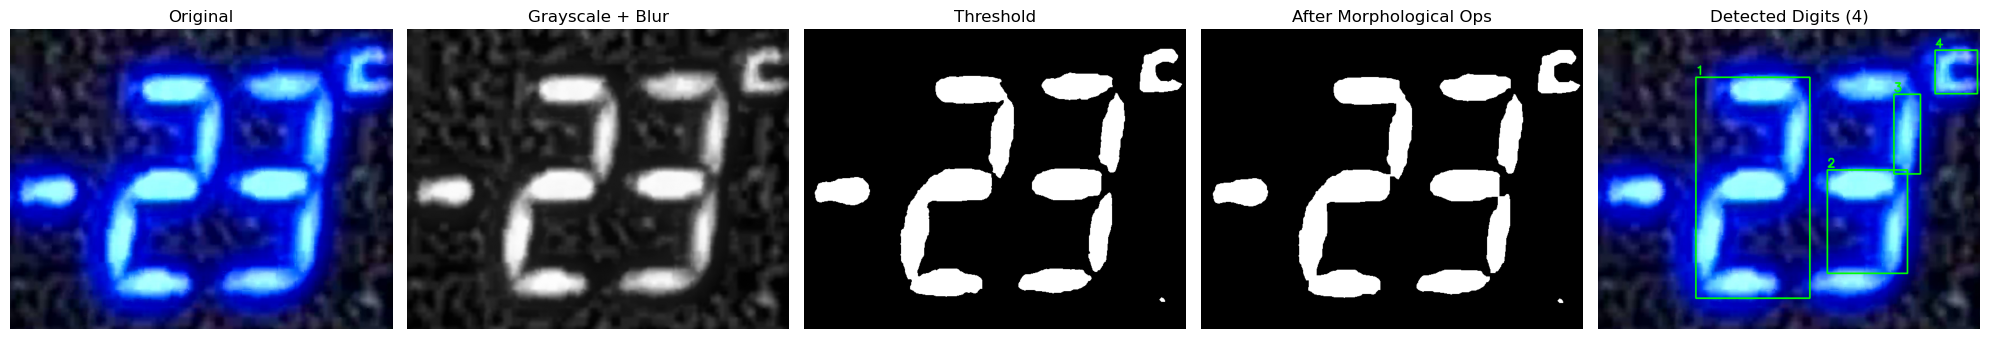


=== Method 2: Connected Components ===


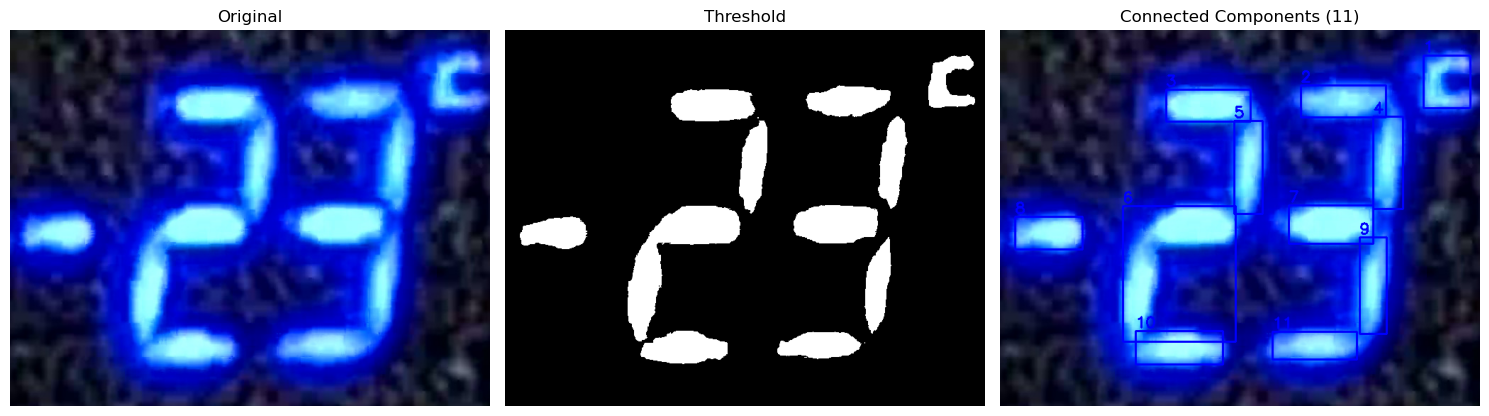

Connected components found: 11 regions


In [ ]:
import cv2
import imutils
import matplotlib.pyplot as plt
import numpy as np

def detect_seven_segment_digits(image_path, debug=False):
    """
    Optimized detection for seven-segment displays
    """
    
    # === Step 1: Load image ===
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Could not load image: {image_path}")
    
    original = img.copy()
    height, width = img.shape[:2]
    print(f"Image dimensions: {width}x{height}")

    # === Step 2: Enhanced preprocessing for seven-segment displays ===
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply strong Gaussian blur to merge nearby segments
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Use Otsu thresholding but invert it (digits are bright on dark background)
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # === Step 3: Morphological operations to merge segments ===
    # Create larger kernel to connect nearby segments within a digit
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, (8, 12))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel_close)
    
    # Fill holes within digits
    kernel_fill = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    filled = cv2.morphologyEx(closed, cv2.MORPH_CLOSE, kernel_fill)
    
    # Remove small noise
    kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    cleaned = cv2.morphologyEx(filled, cv2.MORPH_OPEN, kernel_open)

    # === Step 4: Find contours ===
    cnts = cv2.findContours(cleaned.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    print(f"Found {len(cnts)} total contours after morphological operations")

    # === Step 5: Filter for digit-like contours ===
    digitCnts = []
    
    # Calculate average dimensions to help with filtering
    if cnts:
        areas = [cv2.contourArea(c) for c in cnts]
        avg_area = np.mean(areas)
        area_threshold = max(500, avg_area * 0.1)  # Adaptive threshold
    else:
        area_threshold = 500
    
    for i, c in enumerate(cnts):
        (x, y, w, h) = cv2.boundingRect(c)
        area = cv2.contourArea(c)
        aspect_ratio = w / float(h)
        
        # More restrictive criteria for seven-segment digits
        if (w >= 15 and h >= 25 and          # Minimum size
            area >= area_threshold and        # Sufficient area
            0.3 <= aspect_ratio <= 1.2 and   # Reasonable aspect ratio for digits
            h >= w * 0.8):                   # Height should be at least 80% of width for most digits
            
            digitCnts.append(c)
            print(f"Digit {len(digitCnts)}: x={x}, y={y}, w={w}, h={h}, area={area:.0f}, aspect={aspect_ratio:.2f}")

    print(f"Detected {len(digitCnts)} potential digits after filtering")

    # === Step 6: Additional filtering by position (remove overlapping detections) ===
    if len(digitCnts) > 1:
        # Remove contours that are contained within larger ones
        filtered_cnts = []
        for i, c1 in enumerate(digitCnts):
            (x1, y1, w1, h1) = cv2.boundingRect(c1)
            is_contained = False
            
            for j, c2 in enumerate(digitCnts):
                if i != j:
                    (x2, y2, w2, h2) = cv2.boundingRect(c2)
                    # Check if c1 is contained within c2
                    if (x1 >= x2 and y1 >= y2 and 
                        x1 + w1 <= x2 + w2 and y1 + h1 <= y2 + h2):
                        is_contained = True
                        break
            
            if not is_contained:
                filtered_cnts.append(c1)
        
        digitCnts = filtered_cnts
        print(f"After overlap removal: {len(digitCnts)} digits")

    # === Step 7: Sort left-to-right ===
    digitCnts = sorted(digitCnts, key=lambda c: cv2.boundingRect(c)[0])

    # === Step 8: Draw results ===
    output = original.copy()
    for i, c in enumerate(digitCnts):
        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)
        # Add digit number label
        cv2.putText(output, str(i+1), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 
                   0.7, (0, 255, 0), 2)

    # === Step 9: Visualization ===
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 5, 1)
    plt.title("Original")
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 5, 2)
    plt.title("Grayscale + Blur")
    plt.imshow(blurred, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 5, 3)
    plt.title("Threshold")
    plt.imshow(thresh, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 5, 4)
    plt.title("After Morphological Ops")
    plt.imshow(cleaned, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 5, 5)
    plt.title(f"Detected Digits ({len(digitCnts)})")
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.tight_layout()
    plt.show()
    
    return digitCnts, output, cleaned

def alternative_approach(image_path):
    """
    Alternative approach using template matching or connected components
    """
    img = cv2.imread(image_path)
    original = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Try with different threshold values
    _, thresh1 = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    _, thresh2 = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)
    _, thresh3 = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)
    
    # Use connected components analysis
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh1, connectivity=8)
    
    digit_regions = []
    for i in range(1, num_labels):  # Skip background (label 0)
        area = stats[i, cv2.CC_STAT_AREA]
        width = stats[i, cv2.CC_STAT_WIDTH]
        height = stats[i, cv2.CC_STAT_HEIGHT]
        
        if area > 300 and width > 10 and height > 20:  # Filter by size
            x = stats[i, cv2.CC_STAT_LEFT]
            y = stats[i, cv2.CC_STAT_TOP]
            digit_regions.append((x, y, width, height))
    
    # Draw results
    output = original.copy()
    for i, (x, y, w, h) in enumerate(digit_regions):
        cv2.rectangle(output, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.putText(output, str(i+1), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.title("Threshold")
    plt.imshow(thresh1, cmap="gray")
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.title(f"Connected Components ({len(digit_regions)})")
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()
    
    return digit_regions

# === Usage ===
if __name__ == "__main__":
    image_path = "digits_crops/digit_1.png"
    
    print("=== Method 1: Enhanced Morphological Approach ===")
    try:
        digitCnts, output, processed = detect_seven_segment_digits(image_path)
    except Exception as e:
        print(f"Error in method 1: {e}")
    
    print("\n=== Method 2: Connected Components ===")
    try:
        digit_regions = alternative_approach(image_path)
        print(f"Connected components found: {len(digit_regions)} regions")
    except Exception as e:
        print(f"Error in method 2: {e}")

=== Enhanced Seven-Segment Detection ===
Image dimensions: 677x531
Found 5 total contours after morphological operations
Digit 1: x=174, y=85, w=202, h=391, area=25880, aspect=0.52
Digit 2: x=383, y=79, w=189, h=391, area=22952, aspect=0.48
Digit 3: x=598, y=37, w=75, h=77, area=3297, aspect=0.97
Detected 3 potential digits after filtering
After overlap removal: 3 digits


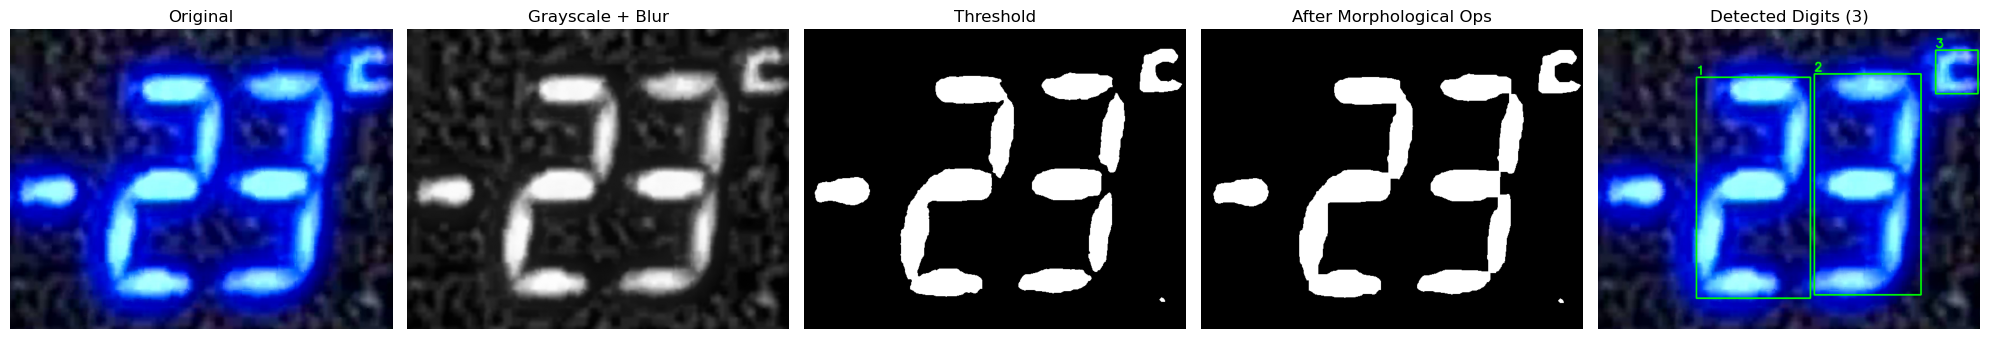

Final result: 3 digits detected

Final digit coordinates:
Digit 1: x=174, y=85, width=202, height=391
Digit 2: x=383, y=79, width=189, height=391
Digit 3: x=598, y=37, width=75, height=77

=== Alternative: Connected Components (for comparison) ===


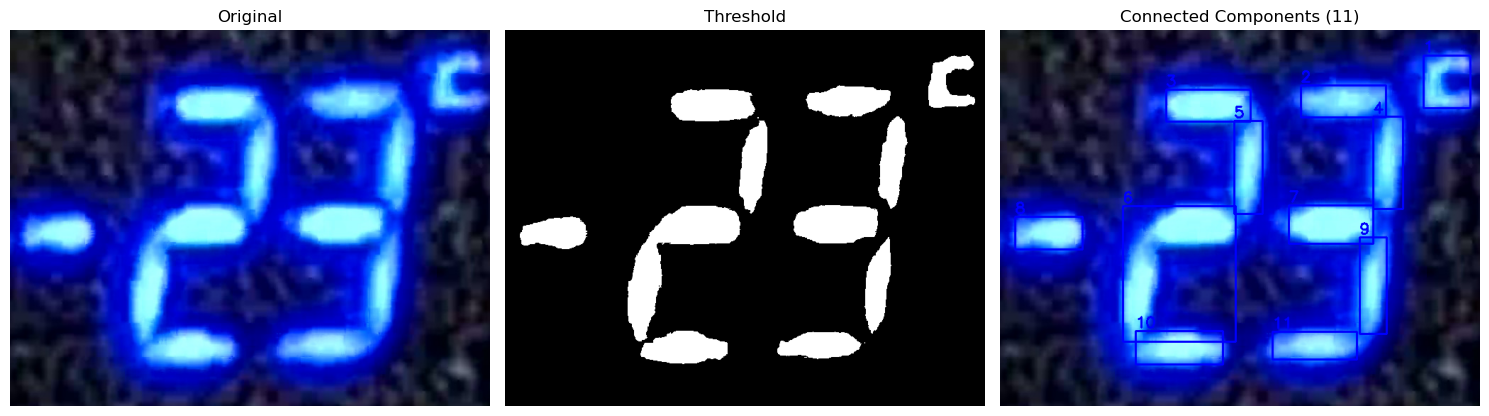

Connected components found: 11 regions


In [24]:
import cv2
import imutils
import matplotlib.pyplot as plt
import numpy as np

def detect_seven_segment_digits(image_path, debug=False):
    """
    Optimized detection for seven-segment displays
    """
    
    # === Step 1: Load image ===
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Could not load image: {image_path}")
    
    original = img.copy()
    height, width = img.shape[:2]
    print(f"Image dimensions: {width}x{height}")

    # === Step 2: Enhanced preprocessing for seven-segment displays ===
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply strong Gaussian blur to merge nearby segments
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Use Otsu thresholding but invert it (digits are bright on dark background)
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # === Step 3: Morphological operations to merge segments ===
    # Create larger kernel to connect nearby segments within a digit
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, (12, 17))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel_close)
    
    # Fill holes within digits
    kernel_fill = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))
    filled = cv2.morphologyEx(closed, cv2.MORPH_CLOSE, kernel_fill)
    
    # Remove small noise
    kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    cleaned = cv2.morphologyEx(filled, cv2.MORPH_OPEN, kernel_open)

    # === Step 4: Find contours ===
    cnts = cv2.findContours(cleaned.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    print(f"Found {len(cnts)} total contours after morphological operations")

    # === Step 5: Filter for digit-like contours ===
    digitCnts = []
    
    # Calculate average dimensions to help with filtering
    if cnts:
        areas = [cv2.contourArea(c) for c in cnts]
        avg_area = np.mean(areas)
        area_threshold = max(500, avg_area * 0.1)  # Adaptive threshold
    else:
        area_threshold = 500
    
    for i, c in enumerate(cnts):
        (x, y, w, h) = cv2.boundingRect(c)
        area = cv2.contourArea(c)
        aspect_ratio = w / float(h)
        
        # More restrictive criteria for seven-segment digits
        if (w >= 15 and h >= 25 and          # Minimum size
            area >= area_threshold and        # Sufficient area
            0.3 <= aspect_ratio <= 1.2 and   # Reasonable aspect ratio for digits
            h >= w * 0.8):                   # Height should be at least 80% of width for most digits
            
            digitCnts.append(c)
            print(f"Digit {len(digitCnts)}: x={x}, y={y}, w={w}, h={h}, area={area:.0f}, aspect={aspect_ratio:.2f}")

    print(f"Detected {len(digitCnts)} potential digits after filtering")

    # === Step 6: Additional filtering by position (remove overlapping detections) ===
    if len(digitCnts) > 1:
        # Remove contours that are contained within larger ones
        filtered_cnts = []
        for i, c1 in enumerate(digitCnts):
            (x1, y1, w1, h1) = cv2.boundingRect(c1)
            is_contained = False
            
            for j, c2 in enumerate(digitCnts):
                if i != j:
                    (x2, y2, w2, h2) = cv2.boundingRect(c2)
                    # Check if c1 is contained within c2
                    if (x1 >= x2 and y1 >= y2 and 
                        x1 + w1 <= x2 + w2 and y1 + h1 <= y2 + h2):
                        is_contained = True
                        break
            
            if not is_contained:
                filtered_cnts.append(c1)
        
        digitCnts = filtered_cnts
        print(f"After overlap removal: {len(digitCnts)} digits")

    # === Step 7: Sort left-to-right ===
    digitCnts = sorted(digitCnts, key=lambda c: cv2.boundingRect(c)[0])

    # === Step 8: Draw results ===
    output = original.copy()
    for i, c in enumerate(digitCnts):
        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)
        # Add digit number label
        cv2.putText(output, str(i+1), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 
                   0.7, (0, 255, 0), 2)

    # === Step 9: Visualization ===
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 5, 1)
    plt.title("Original")
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 5, 2)
    plt.title("Grayscale + Blur")
    plt.imshow(blurred, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 5, 3)
    plt.title("Threshold")
    plt.imshow(thresh, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 5, 4)
    plt.title("After Morphological Ops")
    plt.imshow(cleaned, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 5, 5)
    plt.title(f"Detected Digits ({len(digitCnts)})")
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.tight_layout()
    plt.show()
    
    return digitCnts, output, cleaned

def alternative_approach(image_path):
    """
    Alternative approach using template matching or connected components
    """
    img = cv2.imread(image_path)
    original = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Try with different threshold values
    _, thresh1 = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    _, thresh2 = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)
    _, thresh3 = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)
    
    # Use connected components analysis
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh1, connectivity=8)
    
    digit_regions = []
    for i in range(1, num_labels):  # Skip background (label 0)
        area = stats[i, cv2.CC_STAT_AREA]
        width = stats[i, cv2.CC_STAT_WIDTH]
        height = stats[i, cv2.CC_STAT_HEIGHT]
        
        if area > 300 and width > 10 and height > 20:  # Filter by size
            x = stats[i, cv2.CC_STAT_LEFT]
            y = stats[i, cv2.CC_STAT_TOP]
            digit_regions.append((x, y, width, height))
    
    # Draw results
    output = original.copy()
    for i, (x, y, w, h) in enumerate(digit_regions):
        cv2.rectangle(output, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.putText(output, str(i+1), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.title("Threshold")
    plt.imshow(thresh1, cmap="gray")
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.title(f"Connected Components ({len(digit_regions)})")
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()
    
    return digit_regions

# === Usage ===
if __name__ == "__main__":
    image_path = "digits_crops/digit_1.png"
    
    print("=== Enhanced Seven-Segment Detection ===")
    try:
        digitCnts, output, processed = detect_seven_segment_digits(image_path, debug=True)
        print(f"Final result: {len(digitCnts)} digits detected")
        
        # Print final bounding box coordinates
        print("\nFinal digit coordinates:")
        for i, c in enumerate(digitCnts):
            (x, y, w, h) = cv2.boundingRect(c)
            print(f"Digit {i+1}: x={x}, y={y}, width={w}, height={h}")
            
    except Exception as e:
        print(f"Error: {e}")
    
    print("\n=== Alternative: Connected Components (for comparison) ===")
    try:
        digit_regions = alternative_approach(image_path)
        print(f"Connected components found: {len(digit_regions)} regions")
    except Exception as e:
        print(f"Error in alternative method: {e}")

# === Additional utility functions ===
def fine_tune_parameters(image_path):
    """
    Interactive parameter tuning function
    """
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    print("Trying different parameter combinations...")
    
    # Test different morphological kernel sizes
    kernel_sizes = [(4, 6), (6, 8), (8, 10), (8, 12), (10, 14)]
    
    for i, (kw, kh) in enumerate(kernel_sizes):
        print(f"\nTesting kernel size: {kw}x{kh}")
        
        blurred = cv2.GaussianBlur(gray, (3, 3), 0)
        _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kw, kh))
        morphed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
        
        cnts = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        
        # Simple filtering
        digit_count = 0
        for c in cnts:
            area = cv2.contourArea(c)
            if area > 200:
                digit_count += 1
        
        print(f"  Result: {digit_count} potential digits found")

def extract_digits_with_padding(image_path, digitCnts, padding=5):
    """
    Extract individual digits with better padding
    """
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    extracted_digits = []
    for i, c in enumerate(digitCnts):
        (x, y, w, h) = cv2.boundingRect(c)
        
        # Calculate padding that maintains aspect ratio
        pad_x = max(padding, int(w * 0.1))
        pad_y = max(padding, int(h * 0.1))
        
        # Ensure we don't go out of bounds
        x_start = max(0, x - pad_x)
        y_start = max(0, y - pad_y)
        x_end = min(img.shape[1], x + w + pad_x)
        y_end = min(img.shape[0], y + h + pad_y)
        
        digit_roi = gray[y_start:y_end, x_start:x_end]
        extracted_digits.append(digit_roi)
        
        # Save with better naming
        cv2.imwrite(f"digit_{i+1}_extracted.png", digit_roi)
    
    return extracted_digits